In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.metrics import make_scorer, roc_auc_score,confusion_matrix
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import RocCurveDisplay,roc_curve
from sklearn import metrics


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import KFold,StratifiedKFold

#The model
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest


#For preprocessing
from sklearn.preprocessing import MinMaxScaler,StandardScaler

# from tqdm import tqdm
from tqdm.notebook import tqdm
import warnings
warnings.simplefilter("ignore")

In [15]:
class AnomalyDetectionDataLoader:

    def __init__(self, file_path, test_size=0.15, random_state=42):
        self.file_path = file_path
        self.test_size = test_size
        self.random_state = random_state
        self.data = None
        self.target = None
        self.xtrain = None
        self.xtest = None
        self.ytrain = None
        self.ytest = None
        self.scaler = MinMaxScaler()

    def load_data_creditcard(self):
        # Charger les données depuis le fichier CSV
        self.data = pd.read_csv(self.file_path)

        # Supprimer les duplicatas en conservant la dernière occurrence
        self.data.drop_duplicates(keep="last", inplace=True)

        # Extraire la variable cible et les caractéristiques
        self.target = self.data["Class"]
        self.data = self.data.drop(["Class", "Time"], axis=1)

    def load_data_backdoor(self):
        # Charger les données depuis le fichier CSV
        self.data = pd.read_csv(self.file_path)

        # Supprimer les duplicatas en conservant la dernière occurrence
        self.data.drop_duplicates(keep="last", inplace=True)

        # Extraire la variable cible et les caractéristiques
        self.target = self.data["class"]
        self.data.drop(["class"], axis=1,inplace=True)

    def preprocess_data(self):
        # Normaliser les caractéristiques avec Min-Max Scaling
        data_scaled_array = self.scaler.fit_transform(self.data)
        self.data = pd.DataFrame(data_scaled_array, columns=self.data.columns)

    def split_data(self):
        # Diviser les données en ensembles d'entraînement et de test
        self.xtrain, self.xtest, self.ytrain, self.ytest = train_test_split(
            self.data, self.target, test_size=self.test_size, random_state=self.random_state, shuffle=True)

    def get_train_data(self):
        return self.xtrain, self.ytrain

    def get_test_data(self):
        return self.xtest, self.ytest

    def get_scaler(self):
        return self.scaler

    def get_data(self):
      return self.data, self.target



In [16]:
def transform_target(target):
    """Args:
        target: np.ndarry or pd.DataFrame
    """
    n=target.shape[0]
    if isinstance(target,np.ndarray):
        target[target==1]=-1
        target[target==0]=1

    elif isinstance(target,pd.DataFrame) or isinstance(target,pd.Series):
        target[target==1]=-1
        target[target==0]=1
    return target


def inverse_transform_target(target):
    n=target.shape[0]
    if isinstance(target,pd.DataFrame) or isinstance(target,pd.Series):
        target[target==1]=0
        target[target==-1]=1

    elif isinstance(target,np.ndarray):
        target[target==1]=0
        target[target==-1]=1
    return target

In [17]:
def confusin_matrix_display(ytest,ypred):
    metrics.ConfusionMatrixDisplay(confusion_matrix(ytest,ypred)).plot()
    plt.title("Confusion Matrix")
    plt.show()

def precision_recall_display(ytest, ypred):
    precision, recall, _ = precision_recall_curve(ytest, ypred)
    PrecisionRecallDisplay(precision=precision, recall=recall).plot()
    plt.title("Precision_Recall_Curve")
    plt.show()

def roc_curve_disolay(ytest, ypred):
    fpr, tpr, thresholds = metrics.roc_curve(ytest, ypred)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    print(f"roc_auc {roc_auc}")
    display.plot()
    plt.title("ROC_Curve")
    plt.show()

def scores(ytest,ypred):
    df=pd.DataFrame({"f1_score" : [f1_score(ytest,ypred)],
                     "accuracy_score" : [accuracy_score(ytest,ypred)],
                     "precision_score" : [precision_score(ytest,ypred)],
                     "recall_score" : [recall_score(ytest,ypred)]
    })
    print(df)
    return df

def evaluation(ytrue,ypred):
    confusin_matrix_display(ytrue,ypred)
    precision_recall_display(ytrue, ypred)
    roc_curve_disolay(ytrue, ypred)
    scores(ytrue,ypred)

In [18]:
class CustomGridSearchCV:

    def __init__(self, estimator, param_grid, n_splits=5, random_state=42):
        self.estimator = estimator
        self.param_grid = param_grid
        self.n_splits = n_splits
        self.random_state = random_state
        self.best_score = 0
        self.best_params = None
        self.best_estimator = None

    def fit(self, X, y):


        param_grid = ParameterGrid(self.param_grid)
        # skf=StratifiedKFold(n_splits=self.n_splits, random_state=None, shuffle=False)

        for params in tqdm(param_grid):


            total_score = 0

            # Itérer sur les plis de la validation croisée
            # for train_index, val_index in tqdm(skf.split(X,y)):
            # xtrain_fold, xval_fold = X.iloc[train_index], X.iloc[val_index]
            # ytrain_fold, yval_fold = y.iloc[train_index], y.iloc[val_index]

            # Entraîner le modèle
            model = self.estimator.set_params(**params)

            # Faire des prédictions
            ypred_val = model.fit_predict(X)
            ypred_val = inverse_transform_target(ypred_val)

            avg_score = f1_score(ypred_val, y)

            # Afficher les paramètres et le score moyen
            print("Paramètres:", params)
            print("Score moyen (f1_score):", avg_score)
            print(" ")

            if avg_score > self.best_score:
                self.best_score = avg_score
                self.best_params = params
                self.best_estimator=model

        # Afficher les meilleurs paramètres
        print("Meilleurs paramètres :", self.best_params)
        print("Meilleur score moyen (f1_score) :", self.best_score)
    def predict(self,X):
        return self.best_estimator.fit_predict(X)

In [19]:
# Utilisation de la classe
# file_path = "/home/dah/anomalie_detection/anomalie_detection/data/creditcard.csv"
file_path = "/content/drive/Othercomputers/Mon ordinateur portable/ISIMA/3A/anomalie_detection/data/creditcard.csv"
data_loader = AnomalyDetectionDataLoader(file_path=file_path)
data_loader.load_data_creditcard()
data_loader.preprocess_data()

x, y = data_loader.get_data()
scaler = data_loader.get_scaler()

In [20]:
best_par={
           'contamination': [0.003],
           'n_neighbors': [10, 20, 50, 100, 120,150,160]
}
model=CustomGridSearchCV(estimator=LocalOutlierFactor(), param_grid=best_par, n_splits=5, random_state=42)
model.fit(x,y)

  0%|          | 0/7 [00:00<?, ?it/s]

Paramètres: {'contamination': 0.003, 'n_neighbors': 10}
Score moyen (f1_score): 0.0
 
Paramètres: {'contamination': 0.003, 'n_neighbors': 20}
Score moyen (f1_score): 0.0
 
Paramètres: {'contamination': 0.003, 'n_neighbors': 50}
Score moyen (f1_score): 0.0
 
Paramètres: {'contamination': 0.003, 'n_neighbors': 100}
Score moyen (f1_score): 0.001509433962264151
 
Paramètres: {'contamination': 0.003, 'n_neighbors': 120}
Score moyen (f1_score): 0.003018867924528302
 
Paramètres: {'contamination': 0.003, 'n_neighbors': 150}
Score moyen (f1_score): 0.004528301886792453
 
Paramètres: {'contamination': 0.003, 'n_neighbors': 160}
Score moyen (f1_score): 0.012075471698113209
 
Meilleurs paramètres : {'contamination': 0.003, 'n_neighbors': 160}
Meilleur score moyen (f1_score) : 0.012075471698113209


In [21]:
print(model.best_params)

{'contamination': 0.003, 'n_neighbors': 160}


In [22]:
# model.best_params
params=model.best_params

In [23]:
cl=LocalOutlierFactor(**params)

In [24]:
ypred=cl.fit_predict(x)

In [25]:
ypred=inverse_transform_target(ypred)

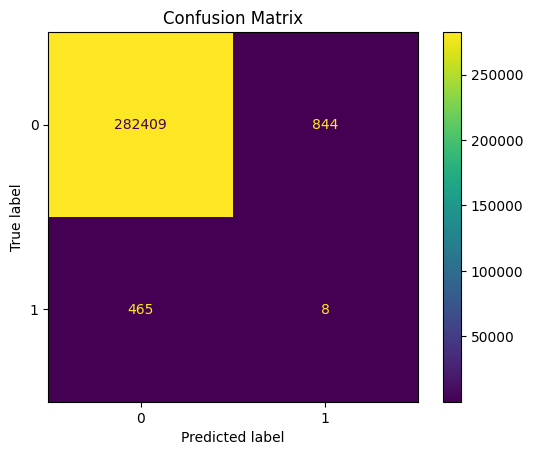

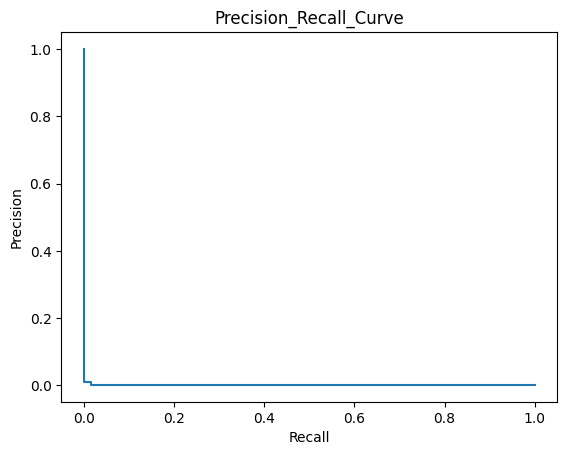

roc_auc 0.5069668254429367


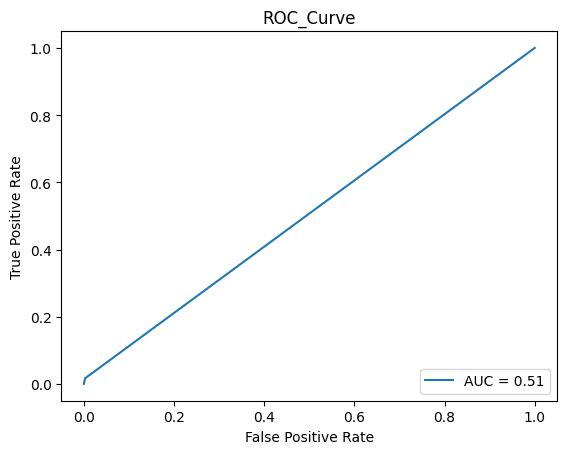

   f1_score  accuracy_score  precision_score  recall_score
0  0.012075        0.995386          0.00939      0.016913


In [26]:
evaluation(y,ypred)

In [27]:
# Serialize the object to a file
import pickle
with open("./Lof_creditcard.pickle", "wb") as file:
    pickle.dump(cl, file)

TSNE visualisation

In [28]:
df = pd.read_csv('/content/drive/Othercomputers/Mon ordinateur portable/ISIMA/3A/anomalie_detection/data/creditcard.csv', sep=',')
label = df.iloc[:, -1].copy()
df = df.drop(['Class', 'Time'], axis=1)
df = pd.DataFrame(MinMaxScaler().fit_transform(df), columns=df.columns)

In [29]:
viz_y = cl.fit_predict(df)
viz_y[viz_y == 1] = 0 # -1 == anomaly, else 1
viz_y[viz_y == -1] = 1

In [30]:
import pickle
src_path = "/content/drive/Othercomputers/Mon ordinateur portable/ISIMA/3A/anomalie_detection/src"

In [31]:
with open(src_path + "/X_embedded_creditcard.pickle", "rb") as file:
    X_embedded = pickle.load(file)

In [32]:
with open(src_path + "/embedded_index_creditcard.pickle", "rb") as file:
    index = pickle.load(file)

Text(0.5, 1.0, 'Local Outlier Factor')

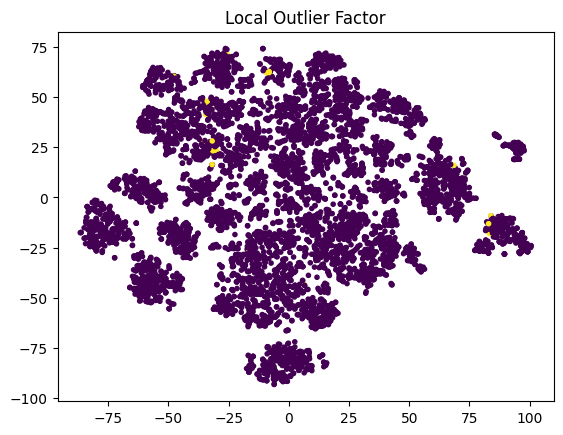

In [33]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=viz_y[index], marker='.')
plt.title("Local Outlier Factor")

BACKDOOR

In [34]:
# Utilisation de la classe
# file_path = "/home/dah/anomalie_detection/anomalie_detection/data/creditcard.csv"
file_path = "/content/drive/Othercomputers/Mon ordinateur portable/ISIMA/3A/anomalie_detection/data/UNSW_NB15_traintest_backdoor.csv"
data_loader = AnomalyDetectionDataLoader(file_path=file_path)
data_loader.load_data_backdoor()
data_loader.preprocess_data()

x, y = data_loader.get_data()
scaler = data_loader.get_scaler()

In [35]:
best_par={
           'contamination': [0.003],
           'n_neighbors': [10, 20, 50, 100, 120,150,160]
}
model=CustomGridSearchCV(estimator=LocalOutlierFactor(), param_grid=best_par, n_splits=5, random_state=42)
model.fit(x,y)

  0%|          | 0/7 [00:00<?, ?it/s]

Paramètres: {'contamination': 0.003, 'n_neighbors': 10}
Score moyen (f1_score): 0.14946286781877627
 
Paramètres: {'contamination': 0.003, 'n_neighbors': 20}
Score moyen (f1_score): 0.1335824381130313
 
Paramètres: {'contamination': 0.003, 'n_neighbors': 50}
Score moyen (f1_score): 0.1588042970574498
 
Paramètres: {'contamination': 0.003, 'n_neighbors': 100}
Score moyen (f1_score): 0.15226529659037832
 
Paramètres: {'contamination': 0.003, 'n_neighbors': 120}
Score moyen (f1_score): 0.15693601120971507
 
Paramètres: {'contamination': 0.003, 'n_neighbors': 150}
Score moyen (f1_score): 0.1588042970574498
 
Paramètres: {'contamination': 0.003, 'n_neighbors': 160}
Score moyen (f1_score): 0.1588042970574498
 
Meilleurs paramètres : {'contamination': 0.003, 'n_neighbors': 50}
Meilleur score moyen (f1_score) : 0.1588042970574498


In [36]:
print(model.best_params)

{'contamination': 0.003, 'n_neighbors': 50}


In [37]:
# model.best_params
params=model.best_params

In [38]:
cl_backdoor=LocalOutlierFactor(**params)

In [39]:
ypred=cl_backdoor.fit_predict(x)

In [40]:
ypred=inverse_transform_target(ypred)

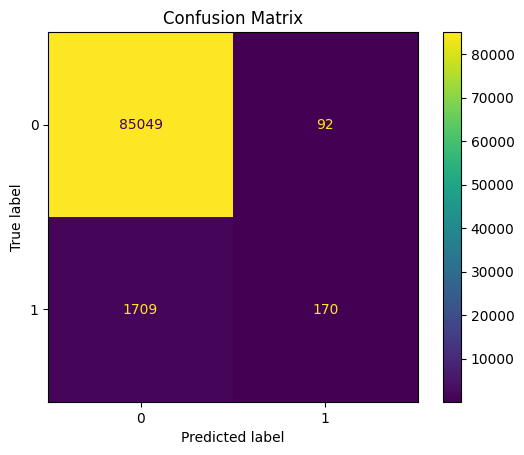

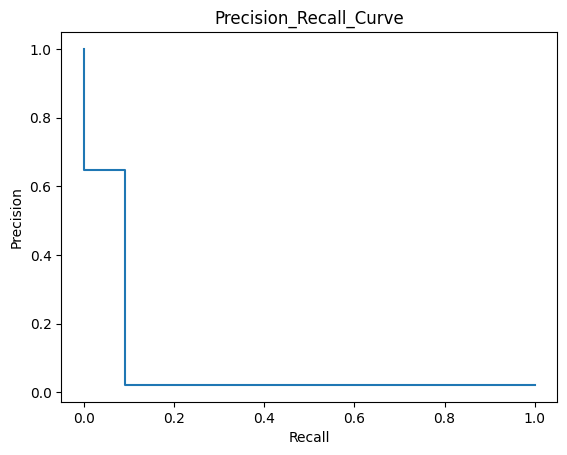

roc_auc 0.5446965478590412


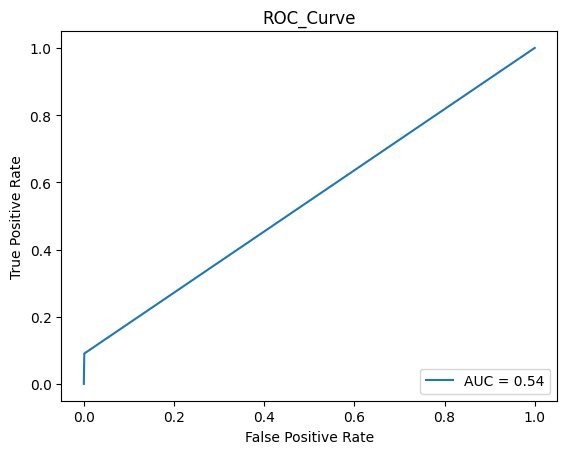

   f1_score  accuracy_score  precision_score  recall_score
0  0.158804        0.979304         0.648855      0.090474


In [41]:
evaluation(y, ypred)

In [42]:
# Serialize the object to a file
import pickle
with open("./Lof_backdoor.pickle", "wb") as file:
    pickle.dump(cl_backdoor, file)

TSNE visualisation backdoor

In [43]:
df = pd.read_csv('/content/drive/Othercomputers/Mon ordinateur portable/ISIMA/3A/anomalie_detection/data/UNSW_NB15_traintest_backdoor.csv', sep=',')
label = df.iloc[:, -1].copy()
df = df.drop(['class'], axis=1)
df = pd.DataFrame(MinMaxScaler().fit_transform(df), columns=df.columns)

In [44]:
viz_y = cl_backdoor.fit_predict(df)
viz_y[viz_y == 1] = 0 # -1 == anomaly, else 1
viz_y[viz_y == -1] = 1

In [45]:
import pickle
src_path = "/content/drive/Othercomputers/Mon ordinateur portable/ISIMA/3A/anomalie_detection/src"

In [46]:
with open(src_path + "/X_embedded_backdoor.pickle", "rb") as file:
    X_embedded = pickle.load(file)

In [47]:
with open(src_path + "/embedded_index_backdoor.pickle", "rb") as file:
    index = pickle.load(file)

Text(0.5, 1.0, 'Local Outlier Factor')

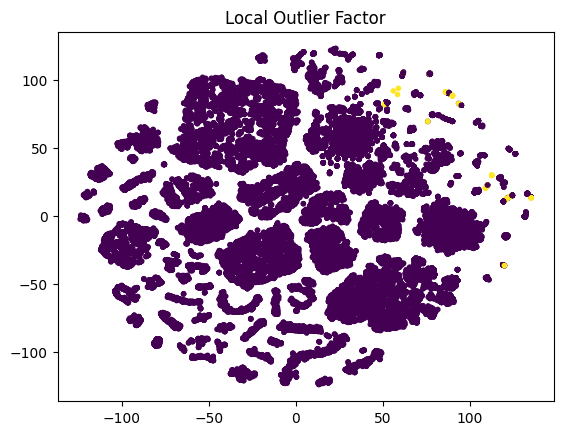

In [48]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=viz_y[index], marker='.')
plt.title("Local Outlier Factor")